# Classification with Neurons that Exhibit High Correlation to Specific Orientations 

In [1]:
from dataset import *

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


/Users/tommasoferracina/bocconi/MMN/MMN-Group-Project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/tommasoferracina/bocconi/MMN/MMN-Group-Project/venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/tommasoferracina/bocconi/MMN/MMN-Group-Project/venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/tommasoferracina/bocconi/MMN/MMN-Group-Project/venv/lib/python3.11/site-packages/

## Data Preparation

In [2]:
static_presentations = get_stimulus_presentations(stimulus_name="static_gratings")
print(f"Found {len(static_presentations)} static gratings presentations")

units = get_units()
print(f"Found {len(units)} units total")

spike_data = get_conditionwise_spike_statistics(stimulus_name="static_gratings")
print(f"Spike statistics shape: {spike_data.shape}")

Found 6000 static gratings presentations
Found 902 units total
Spike statistics shape: (109142, 5)


In [3]:
print("Spike data is a MultiIndex pd Dataframe, with the unit_id + stimulus_condition_id as indices and the following columns:")
spike_data.columns

Spike data is a MultiIndex pd Dataframe, with the unit_id + stimulus_condition_id as indices and the following columns:


Index(['spike_count', 'stimulus_presentation_count', 'spike_mean', 'spike_std',
       'spike_sem'],
      dtype='object')

In [4]:
# take the unit_id as index
spike_data = spike_data.reset_index("unit_id")

In [5]:
# map orientation from stimulus presentations to spike data
static_presentations_unique = static_presentations.reset_index().set_index('stimulus_condition_id')
orientation_map = static_presentations_unique['orientation'].to_dict()

In [6]:
# add orientation to spike data
spike_data['orientation'] = spike_data.index.get_level_values('stimulus_condition_id').map(orientation_map)
spike_data.head()

,unit_id,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem,orientation
stimulus_condition_id,,,,,,,
4787,951805352,70,49,1.428571,1.859659,0.265666,0.0
4787,951805369,61,49,1.244898,1.299529,0.185647,0.0
4787,951805392,137,49,2.795918,2.798657,0.399808,0.0
4787,951805411,58,49,1.183673,1.833411,0.261916,0.0
4787,951805440,49,49,1.000000,1.118034,0.159719,0.0


In [7]:
print("Before:", spike_data['orientation'].unique())
spike_data['orientation'] = spike_data['orientation'].replace('null', np.nan)

spike_data_clean = spike_data.dropna(subset=['orientation'])
print(f"Clean spike data shape: {spike_data_clean.shape}")
print("After:", spike_data_clean['orientation'].unique())

Before: [0.0 30.0 90.0 60.0 'null' 150.0 120.0]
Clean spike data shape: (108240, 7)
After: [  0.  30.  90.  60. 150. 120.]


## Filtering by Orientation Selectivity Index (OSI)

### Calculation
For each neuron, compute its tuning curve (mean firing rate across trials for each orientation). Use:

OSI= (R_preferred - R_orthogonal)/(R_preferred + R_orthogonal)


Justification: Neurons with high OSI (>0.5) are sharply tuned to specific orientations and are critical for encoding orientation information.

In [8]:
# Create tuning curves
tuning_curves = spike_data_clean.groupby(['unit_id', 'orientation']).spike_count.mean().unstack()
print(f"Tuning curves shape: {tuning_curves.shape}")
tuning_curves

Tuning curves shape: (902, 6)


orientation,0.0,30.0,60.0,90.0,120.0,150.0
unit_id,,,,,,
951805352,71.20,71.60,68.95,68.40,74.45,67.70
951805369,61.60,57.55,61.20,59.65,62.30,63.40
951805392,111.15,105.20,106.90,108.40,108.20,106.75
951805411,57.35,51.00,55.95,54.60,58.55,55.80
951805440,42.10,37.85,42.30,38.70,39.70,40.85
...,...,...,...,...,...,...
951827752,142.90,134.70,57.00,85.20,79.50,90.95
951827758,7.70,9.20,15.05,17.55,12.50,8.90
951827774,3.00,4.45,1.50,3.65,2.90,2.30


In [9]:
# Find preferred and orthogonal orientations
preferred_orientation = tuning_curves.idxmax(axis=1)
R_preferred = tuning_curves.max(axis=1)
R_orthogonal = tuning_curves.apply(lambda x: x[(x.idxmax() + 90) % 180], axis=1)  # Adjust for orthogonal orientation

In [10]:
# Calculate OSI
OSI = (R_preferred - R_orthogonal) / (R_preferred + R_orthogonal + 1e-6)  

print("OSI values:", OSI.sort_values(ascending=False).head())

OSI values: unit_id
951810647    0.835667
951810560    0.818086
951815212    0.800089
951819532    0.769541
951827457    0.757154
dtype: float64


### ANOVA

"Do neurons, as a population, respond differently to different orientations of static gratings?"

Null Hypothesis (H₀): All orientations elicit the same mean spike count (no tuning).

Alternative Hypothesis (H₁): At least one orientation elicits a significantly different mean spike count (tuning exists).

In [11]:
# Perform ANOVA for each unit
p_values = spike_data_clean.groupby('unit_id').apply(
    lambda x: f_oneway(*[group.spike_count for name, group in x.groupby('orientation')])[1]
)

print(f"Number of units with significant orientation tuning (p<0.05): {(p_values < 0.05).sum()}")


Number of units with significant orientation tuning (p<0.05): 282


### Adding Region Information and Selecting Well-tuned Neurons

In [12]:
unit_regions = get_units()['ecephys_structure_acronym']

tuning_curves_with_regions = pd.merge(
    unit_regions.rename('ecephys_structure_acronym'),
    tuning_curves,          
    on="unit_id",        
    how="inner"       
)

tuning_curves_with_regions.head()


,ecephys_structure_acronym,0.0,30.0,60.0,90.0,120.0,150.0
unit_id,,,,,,,
951817231,grey,173.00,156.55,168.30,172.95,172.90,167.90
951817222,grey,163.50,161.75,152.50,159.60,164.30,157.20
951817272,grey,325.00,324.50,330.45,329.00,323.85,328.15
951817282,grey,120.05,119.35,112.10,115.75,115.20,117.05
951817316,grey,120.35,118.65,119.50,118.60,119.90,119.95


In [13]:
# Select highly tuned neurons (high OSI and statistically significant)
filtered_neurons = OSI[(OSI > 0.5) & (p_values < 0.05)].index
selected_neurons = tuning_curves_with_regions.loc[filtered_neurons]
selected_neurons_list = selected_neurons.index.unique()

print(f"Number of orientation-selective neurons: {len(selected_neurons)}")
print("\nDistribution across brain regions:")
print(selected_neurons.groupby("ecephys_structure_acronym").size().sort_values(ascending=False))

Number of orientation-selective neurons: 43

Distribution across brain regions:
ecephys_structure_acronym
VISal    15
VISl     10
VISp      9
VISam     6
VISrl     2
grey      1
dtype: int64


## Visualization of Tuning Curves

In [14]:
# Melt orientation columns into rows

vis_df = selected_neurons.reset_index()
melted_df = pd.melt(
    vis_df,
    id_vars=["unit_id", "ecephys_structure_acronym"],
    value_vars=[0.0, 30.0, 60.0, 90.0, 120.0, 150.0],  
    var_name="orientation",
    value_name="spike_count"
)


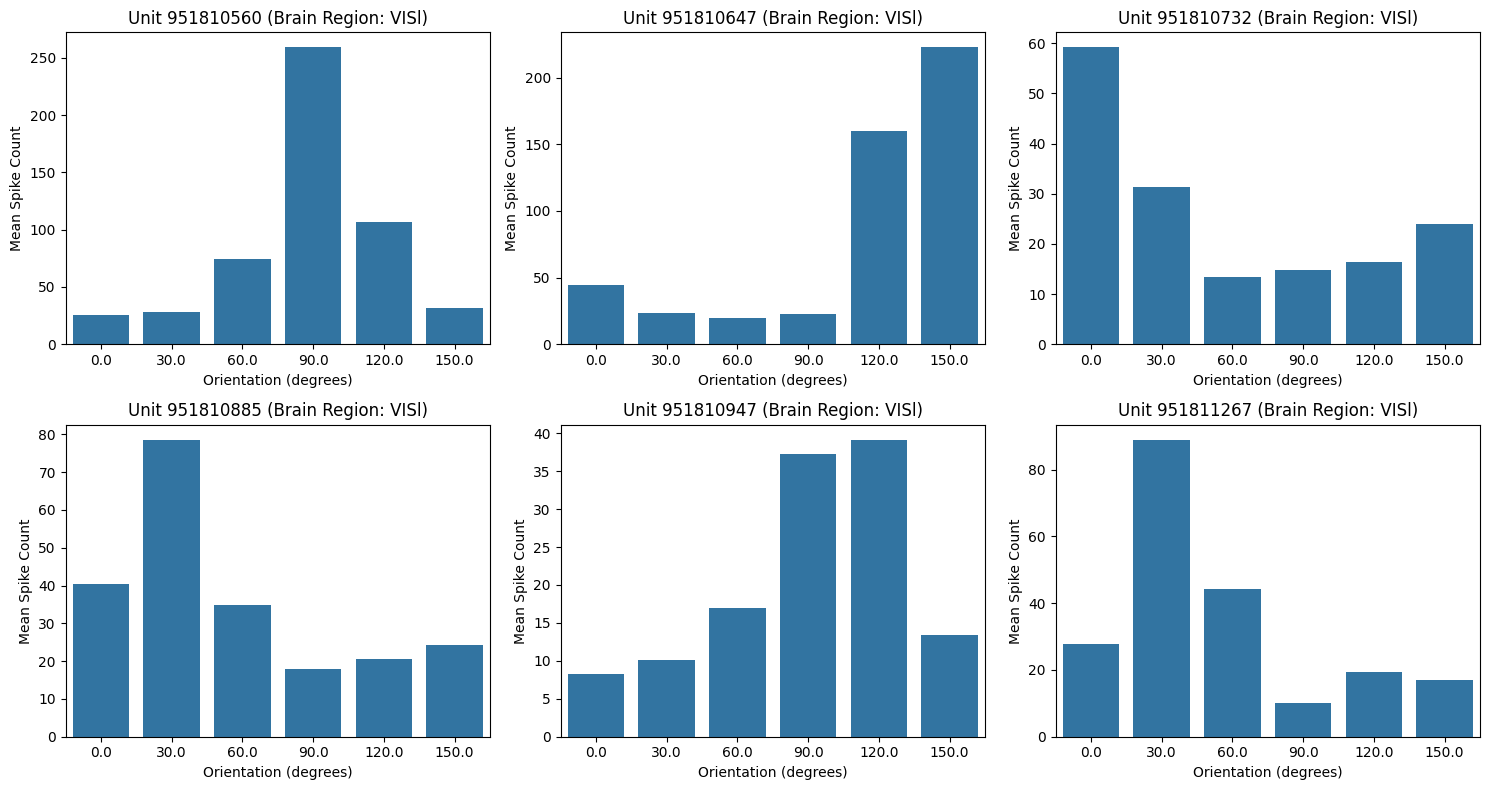

In [15]:
# Plot tuning curves

unit_ids = melted_df["unit_id"].unique()[:6]

fig, axes = plt.subplots(2, 3, figsize=(15,8))

axes = axes.flatten()

for i, unit_id in enumerate(unit_ids):
    # Filter data for the current neuron
    neuron_data = melted_df[melted_df["unit_id"] == unit_id]

    ax = axes[i]
    sns.barplot(
        data=neuron_data,
        x="orientation",
        y="spike_count",
        order=[0.0, 30.0, 60.0, 90.0, 120.0, 150.0],
        ax=ax
    )
    
    brain_region = neuron_data["ecephys_structure_acronym"].iloc[0]
    ax.set_title(f"Unit {unit_id} (Brain Region: {brain_region})", fontsize=12)
    ax.set_xlabel("Orientation (degrees)", fontsize=10)
    ax.set_ylabel("Mean Spike Count", fontsize=10)
    
plt.tight_layout()
plt.show()

# Building the Classifier

## Preparing the Dataset

In [16]:
selected_data = spike_data_clean[spike_data_clean['unit_id'].isin(selected_neurons_list)]

In [17]:
# Create features (X) and target (y)
X = selected_data.pivot_table(
    index='stimulus_condition_id', 
    columns='unit_id', 
    values='spike_count',
    fill_value=0
)

# Get corresponding orientations for each stimulus condition
y = selected_data.groupby('stimulus_condition_id')['orientation'].first()

In [18]:
# Check the distribution of orientations
orientation_counts = y.value_counts()
print("Orientation distribution:")
print(orientation_counts)

Orientation distribution:
0.0      20
30.0     20
90.0     20
60.0     20
150.0    20
120.0    20
Name: orientation, dtype: int64


In [19]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)


In [21]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Random Forest Accuracy:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91         6
        30.0       0.80      0.67      0.73         6
        60.0       0.67      1.00      0.80         6
        90.0       1.00      0.83      0.91         6
       120.0       1.00      1.00      1.00         6
       150.0       0.83      0.83      0.83         6

    accuracy                           0.86        36
   macro avg       0.88      0.86      0.86        36
weighted avg       0.88      0.86      0.86        36

Random Forest Accuracy:
0.8611111111111112


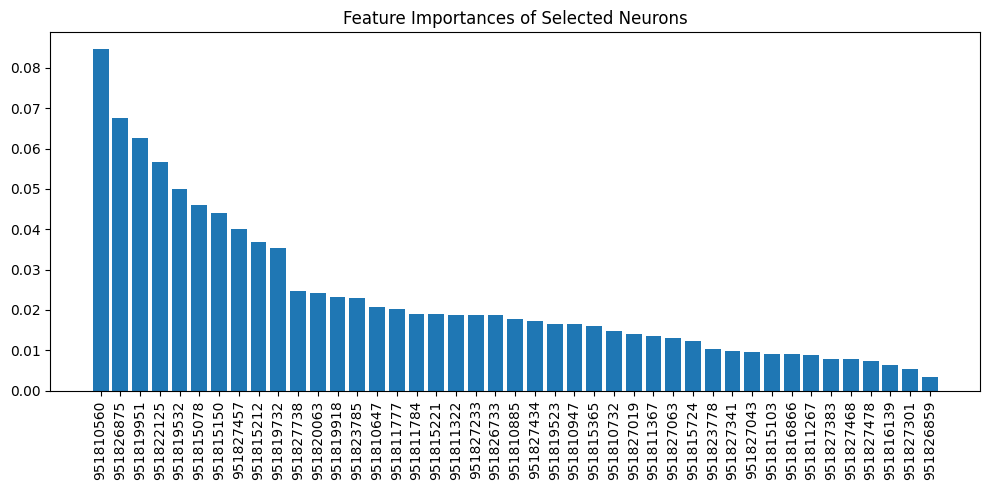

In [22]:
# Plot feature importances to see which neurons contribute most
plt.figure(figsize=(10, 5))
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importances of Selected Neurons')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

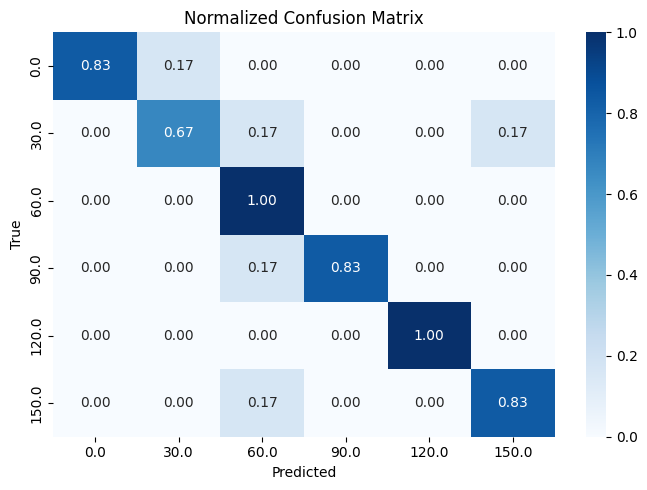

In [23]:
# Visualize classifier performance with a heatmap
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

SVM Accuracy: 0.8333
Logistic Regression Accuracy: 0.8889


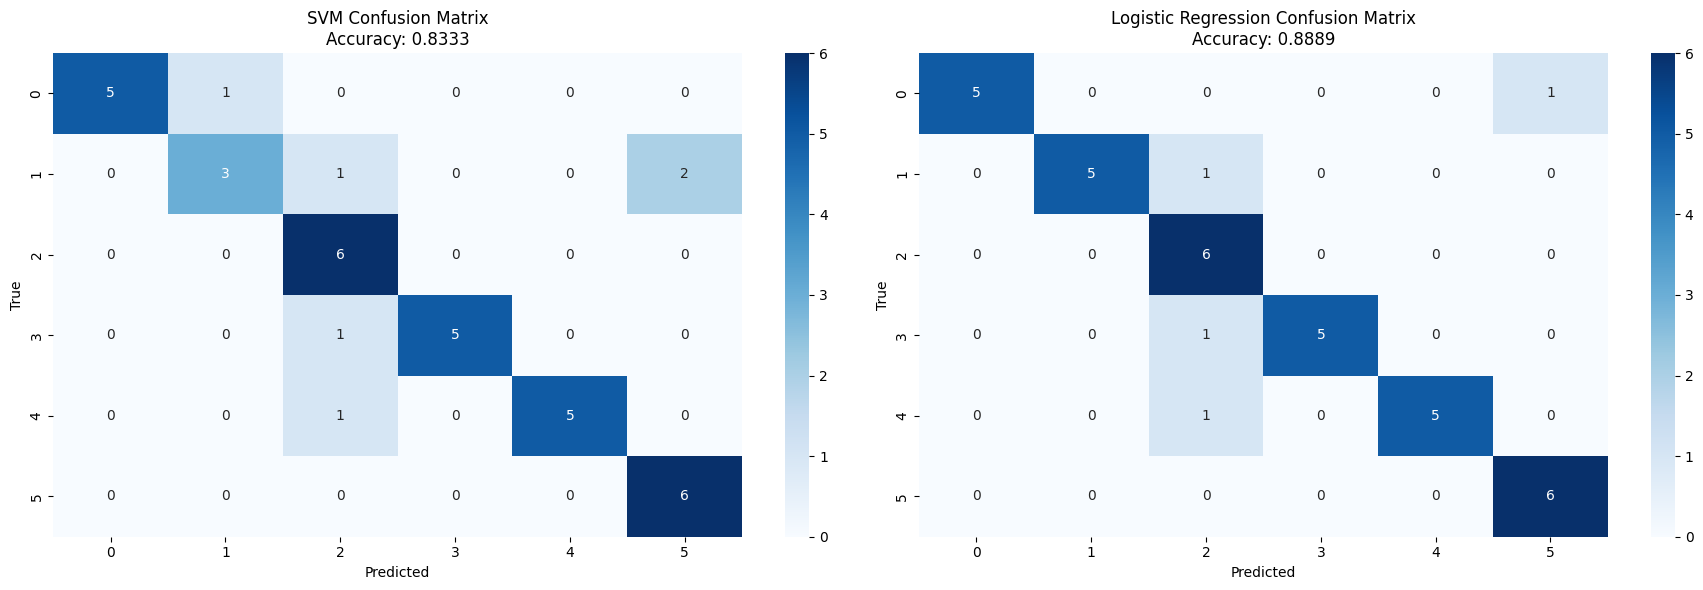

In [24]:
# Support Vector Machine
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Multinomial Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Visualize confusion matrices
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title(f'SVM Confusion Matrix\nAccuracy: {accuracy_svm:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title(f'Logistic Regression Confusion Matrix\nAccuracy: {accuracy_lr:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()